<a href="https://colab.research.google.com/github/Gustavo-dev04/Analise-de-dados-de-acoes-com-ia/blob/main/Modelo_real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


=== PREVISÃO DE AÇÕES NVDA ===

📊 Baixando dados históricos...
✅ Dados baixados - 1257 dias | Último preço: $95.44

🧠 Preparando dados...

📰 Análise de Sentimento:
👍 Positivo (1.00): NVDA reports strong earnings growth... [Fallback]
➖ Neutro (0.00): Analysts raise price target for NVDA... [Fallback]
👍 Positivo (1.00): NVDA stock reaches new high... [Fallback]

🔮 Treinando modelo...
Época 0: MSE = 979.9363
Época 100: MSE = 2.3945
Época 200: MSE = 1.2216
Época 300: MSE = 1.1812
Época 400: MSE = 1.1766
Época 500: MSE = 1.1743
Época 600: MSE = 1.1720
Época 700: MSE = 1.1699
Época 800: MSE = 1.1677
Época 900: MSE = 1.1656
Época 1000: MSE = 1.1634
Época 1100: MSE = 1.1613
Época 1200: MSE = 1.1592
Época 1300: MSE = 1.1572
Época 1400: MSE = 1.1551
Época 1500: MSE = 1.1531
Época 1600: MSE = 1.1511
Época 1700: MSE = 1.1491
Época 1800: MSE = 1.1471
Época 1900: MSE = 1.1451
Época 2000: MSE = 1.1432
Época 2100: MSE = 1.1413
Época 2200: MSE = 1.1394
Época 2300: MSE = 1.1375
Época 2400: MSE = 1.1356

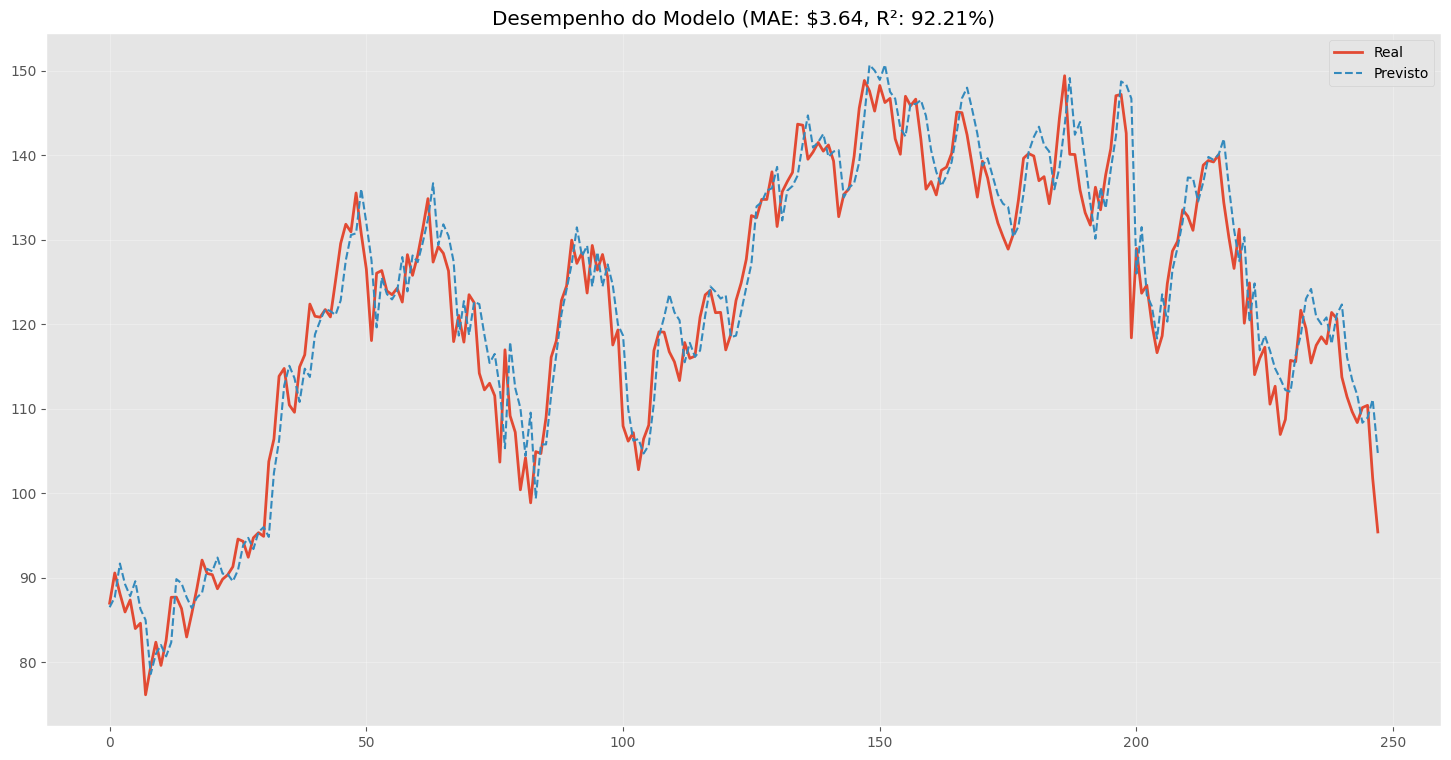


🔍 Resultados:
- Erro Médio Absoluto: $3.64
- RMSE: $4.79
- R²: 92.21%

🔮 Gerando previsões...


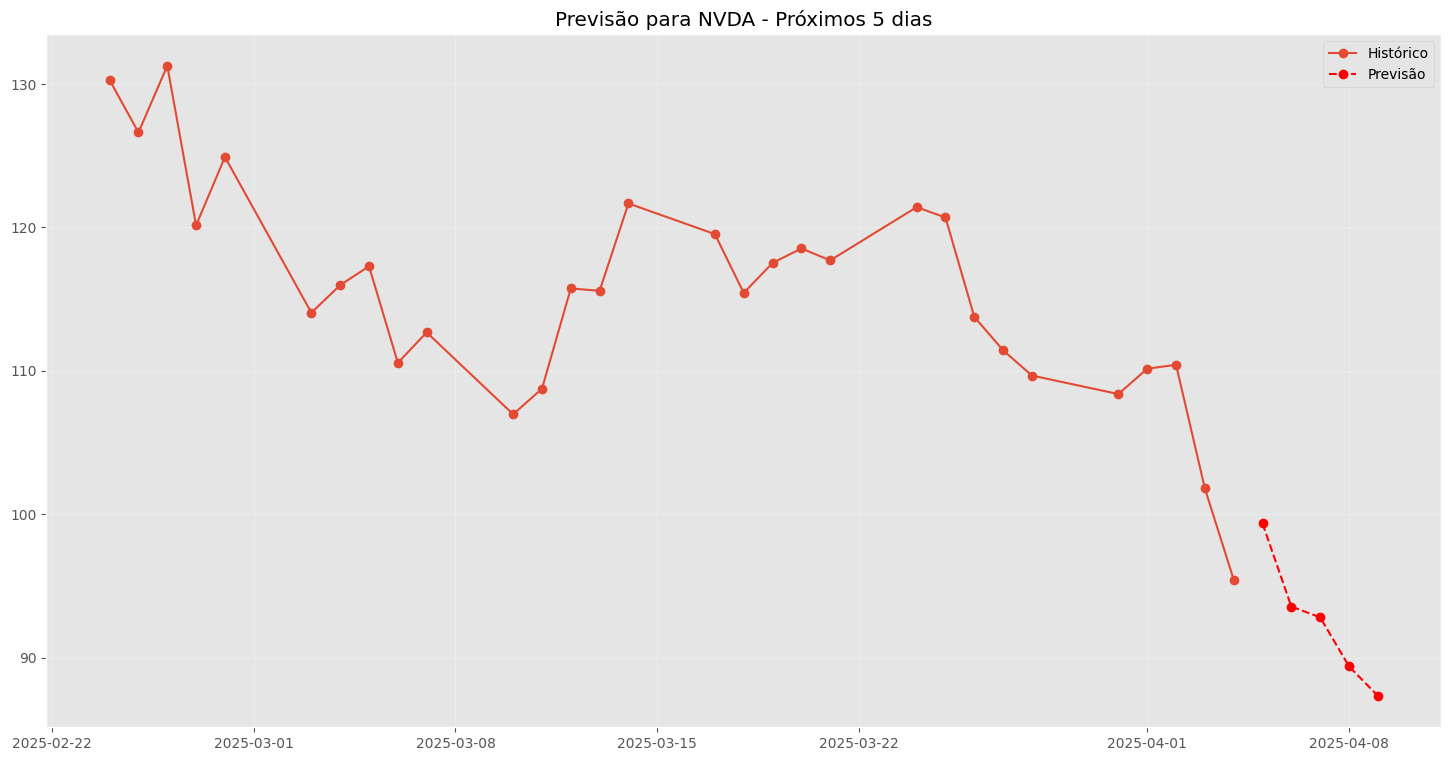


📈 Previsões para os próximos dias:
            forecast
date                
2025-04-05     99.36
2025-04-06     93.56
2025-04-07     92.81
2025-04-08     89.40
2025-04-09     87.34

⏱️ Tempo total: 17.2 segundos


In [7]:
# Importações essenciais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import requests
from bs4 import BeautifulSoup
import feedparser
import time
import warnings
from collections import defaultdict

# Configurações
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18, 9)

# Parâmetros ajustáveis
SYMBOL = 'NVDA'
DAYS_TO_FETCH = 365 * 5  # 2 anos de dados
TEST_SIZE = 0.2
LEARNING_RATE = 0.05
EPOCHS = 10000
VOLATILITY_WINDOW = 20
REQUEST_TIMEOUT = 10
MAX_NEWS_ARTICLES = 10

## --------------------------------------------------
## 1. SISTEMA DE ANÁLISE DE NOTÍCIAS (SEM SPACY/NLTK)
## --------------------------------------------------

class NewsAnalyzer:
    def __init__(self):
        self.session = requests.Session()
        self.session.timeout = REQUEST_TIMEOUT

        # Dicionário de palavras-chave para análise de sentimento
        self.sentiment_words = {
            'positive': ['high', 'rise', 'gain', 'profit', 'growth', 'success', 'beat', 'strong', 'bullish', 'upgrade'],
            'negative': ['low', 'fall', 'drop', 'loss', 'decline', 'cut', 'bearish', 'downgrade', 'miss', 'weak']
        }

        # Fontes de notícias prioritárias
        self.news_sources = [
            {'name': 'Yahoo Finance', 'url': f'https://finance.yahoo.com/quote/{SYMBOL}/news'},
            {'name': 'MarketWatch', 'url': f'https://www.marketwatch.com/investing/stock/{SYMBOL}/news'},
            {'name': 'Nasdaq', 'url': f'https://www.nasdaq.com/market-activity/stocks/{SYMBOL}/news'}
        ]

    def fetch_news(self):
        """Coleta notícias de múltiplas fontes com fallback"""
        articles = []

        for source in self.news_sources:
            try:
                if 'yahoo' in source['url']:
                    articles.extend(self._scrape_yahoo_news(source['url']))
                elif 'marketwatch' in source['url']:
                    articles.extend(self._scrape_marketwatch(source['url']))
                elif 'nasdaq' in source['url']:
                    articles.extend(self._scrape_nasdaq(source['url']))

                if len(articles) >= MAX_NEWS_ARTICLES:
                    break

            except Exception as e:
                print(f"⚠️ Erro em {source['name']}: {str(e)}")
                continue

        # Fallback se nenhuma notícia for encontrada
        if not articles:
            articles = self._get_fallback_news()

        return articles[:MAX_NEWS_ARTICLES]

    def _scrape_yahoo_news(self, url):
        """Scraping do Yahoo Finance"""
        articles = []
        try:
            response = self.session.get(url, timeout=REQUEST_TIMEOUT)
            soup = BeautifulSoup(response.text, 'html.parser')

            for item in soup.select('h3[data-test-locator="headline"]'):
                title = item.text.strip()
                articles.append({'title': title, 'source': 'Yahoo Finance'})
                if len(articles) >= 3:  # Limite por fonte
                    break
        except:
            pass
        return articles

    def _scrape_marketwatch(self, url):
        """Scraping do MarketWatch"""
        articles = []
        try:
            response = self.session.get(url, timeout=REQUEST_TIMEOUT)
            soup = BeautifulSoup(response.text, 'html.parser')

            for item in soup.select('h3.article__headline a'):
                title = item.text.strip()
                articles.append({'title': title, 'source': 'MarketWatch'})
                if len(articles) >= 3:
                    break
        except:
            pass
        return articles

    def _scrape_nasdaq(self, url):
        """Scraping do Nasdaq"""
        articles = []
        try:
            response = self.session.get(url, timeout=REQUEST_TIMEOUT)
            soup = BeautifulSoup(response.text, 'html.parser')

            for item in soup.select('div.feed-item__title a'):
                title = item.text.strip()
                articles.append({'title': title, 'source': 'Nasdaq'})
                if len(articles) >= 3:
                    break
        except:
            pass
        return articles

    def _get_fallback_news(self):
        """Notícias de fallback"""
        return [
            {'title': f'{SYMBOL} reports strong earnings growth', 'source': 'Fallback'},
            {'title': f'Analysts raise price target for {SYMBOL}', 'source': 'Fallback'},
            {'title': f'{SYMBOL} stock reaches new high', 'source': 'Fallback'}
        ]

    def analyze_sentiment(self, articles):
        """Análise de sentimento baseada em palavras-chave"""
        if not articles:
            return 0.0

        sentiment_scores = []
        print("\n📰 Análise de Sentimento:")

        for article in articles:
            title = article['title'].lower()
            score = 0

            # Contagem de palavras positivas/negativas
            pos_count = sum(1 for word in self.sentiment_words['positive'] if word in title)
            neg_count = sum(1 for word in self.sentiment_words['negative'] if word in title)

            # Cálculo do score (-1 a 1)
            total = pos_count + neg_count
            if total > 0:
                score = (pos_count - neg_count) / total

            sentiment_scores.append(score)

            # Classificação simples
            sentiment = "👍 Positivo" if score > 0 else "👎 Negativo" if score < 0 else "➖ Neutro"
            print(f"{sentiment} ({score:.2f}): {article['title'][:60]}... [{article['source']}]")

        return np.mean(sentiment_scores) if sentiment_scores else 0.0

## --------------------------------------------------
## 2. MODELO DE PREVISÃO DE PREÇOS OTIMIZADO
## --------------------------------------------------

class StockPredictor:
    def __init__(self):
        self.learning_rate = LEARNING_RATE
        self.epochs = EPOCHS
        self.weights = None
        self.bias = None
        self.scaler = RobustScaler()
        self.feature_cols = ['close', 'volume', 'ma_5', 'ma_20', 'volatility', 'momentum']
        self.news_analyzer = NewsAnalyzer()

    def prepare_data(self, df):
        """Prepara os dados para treinamento"""
        try:
            # Feature Engineering
            df['returns'] = df['close'].pct_change()
            df['ma_5'] = df['close'].rolling(5).mean()
            df['ma_20'] = df['close'].rolling(20).mean()
            df['volatility'] = df['returns'].rolling(VOLATILITY_WINDOW).std()
            df['momentum'] = df['close'] - df['close'].shift(5)

            # Adiciona sentimento de notícias
            news = self.news_analyzer.fetch_news()
            sentiment = self.news_analyzer.analyze_sentiment(news)
            df['sentiment'] = sentiment

            # Remove valores NA
            df = df.dropna()

            # Separa features e target
            X = df[self.feature_cols]
            y = df['close'].shift(-1).dropna()
            X = X.iloc[:-1]  # Alinha com o target

            # Normalização
            X_scaled = self.scaler.fit_transform(X)

            # Divisão treino-teste temporal
            split_idx = int(len(X) * (1 - TEST_SIZE))
            X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
            y_train, y_test = y[:split_idx], y[split_idx:]

            return X_train, X_test, y_train, y_test, df

        except Exception as e:
            print(f"Erro na preparação: {str(e)}")
            raise

    def train(self, X, y):
        """Treina o modelo com gradiente descendente"""
        n_samples, n_features = X.shape
        self.weights = np.random.randn(n_features) * 0.01
        self.bias = 0
        prev_error = float('inf')

        for epoch in range(self.epochs):
            # Predição
            y_pred = np.dot(X, self.weights) + self.bias

            # Cálculo do erro
            error = np.mean((y_pred - y)**2)

            # Early stopping
            if abs(prev_error - error) < 1e-6 and epoch > 100:
                print(f"✅ Convergência alcançada na época {epoch}")
                break
            prev_error = error

            # Gradientes
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)

            # Atualização dos pesos
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Progresso
            if epoch % 100 == 0:
                print(f"Época {epoch}: MSE = {error:.4f}")

        return error

    def predict(self, X):
        """Faz previsões"""
        return np.dot(X, self.weights) + self.bias

    def evaluate(self, X_test, y_test):
        """Avalia o modelo"""
        y_pred = self.predict(X_test)

        # Métricas
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        # Plot
        plt.figure(figsize=(18, 9))
        plt.plot(y_test.values, label='Real', linewidth=2)
        plt.plot(y_pred, label='Previsto', linestyle='--')
        plt.title(f'Desempenho do Modelo (MAE: ${mae:.2f}, R²: {r2:.2%})')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

        return {'mae': mae, 'rmse': rmse, 'r2': r2}

    def forecast(self, df, days=5):
        """Gera previsões futuras"""
        try:
            forecasts = []
            last_row = df.iloc[-1][self.feature_cols].values.reshape(1, -1)

            for _ in range(days):
                # Prepara dados
                X_scaled = self.scaler.transform(last_row)

                # Faz previsão
                pred = self.predict(X_scaled)[0]
                forecasts.append(pred)

                # Atualiza features para próxima previsão
                new_row = last_row.copy()
                new_row[0][0] = pred  # Atualiza preço
                # Atualiza outras features (simplificado)
                new_row[0][2] = (new_row[0][0] + last_row[0][0] * 4) / 5  # MA_5
                new_row[0][3] = (new_row[0][0] + last_row[0][0] * 19) / 20  # MA_20
                last_row = new_row

            # Cria DataFrame com previsões
            dates = [df.index[-1] + timedelta(days=i+1) for i in range(days)]
            forecast_df = pd.DataFrame({'date': dates, 'forecast': forecasts})
            forecast_df.set_index('date', inplace=True)

            # Plot
            plt.figure(figsize=(18, 9))
            plt.plot(df['close'].iloc[-30:], label='Histórico', marker='o')
            plt.plot(forecast_df['forecast'], label='Previsão',
                    color='red', linestyle='--', marker='o')
            plt.title(f'Previsão para {SYMBOL} - Próximos {days} dias')
            plt.legend()
            plt.grid(alpha=0.3)
            plt.show()

            return forecast_df

        except Exception as e:
            print(f"Erro na previsão: {str(e)}")
            raise

## --------------------------------------------------
## 3. EXECUÇÃO PRINCIPAL
## --------------------------------------------------

def main():
    print(f"\n{'='*50}")
    print(f"=== PREVISÃO DE AÇÕES {SYMBOL} ===")
    print(f"{'='*50}\n")

    try:
        # 1. Baixa dados históricos
        print("📊 Baixando dados históricos...")
        start_time = time.time()
        df = yf.download(SYMBOL, period=f"{DAYS_TO_FETCH//365}y", progress=False)
        df = df[['Close', 'Volume']]
        df.columns = ['close', 'volume']
        print(f"✅ Dados baixados - {len(df)} dias | Último preço: ${df['close'].iloc[-1]:.2f}")

        # 2. Prepara dados
        print("\n🧠 Preparando dados...")
        predictor = StockPredictor()
        X_train, X_test, y_train, y_test, df_processed = predictor.prepare_data(df)

        # 3. Treina modelo
        print("\n🔮 Treinando modelo...")
        train_start = time.time()
        final_error = predictor.train(X_train, y_train)
        print(f"✅ Treino concluído em {time.time()-train_start:.1f}s (MSE final: {final_error:.4f})")

        # 4. Avaliação
        print("\n📊 Avaliando modelo...")
        metrics = predictor.evaluate(X_test, y_test)
        print(f"\n🔍 Resultados:")
        print(f"- Erro Médio Absoluto: ${metrics['mae']:.2f}")
        print(f"- RMSE: ${metrics['rmse']:.2f}")
        print(f"- R²: {metrics['r2']:.2%}")

        # 5. Previsão
        print("\n🔮 Gerando previsões...")
        forecast = predictor.forecast(df_processed)
        print("\n📈 Previsões para os próximos dias:")
        print(forecast.round(2))

    except KeyboardInterrupt:
        print("\n⏹️ Execução interrompida pelo usuário")
    except Exception as e:
        print(f"\n❌ Erro: {str(e)}")
    finally:
        print(f"\n⏱️ Tempo total: {time.time()-start_time:.1f} segundos")

if __name__ == "__main__":
    # Verifica e instala dependências se necessário
    try:
        import yfinance
    except ImportError:
        print("Instalando dependências...")
        import subprocess
        subprocess.run(['pip', 'install', 'yfinance', 'scikit-learn', 'beautifulsoup4', 'feedparser'])

    main()